# Demonstration: QCNN algorithm

In [1]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars

import sys
sys.path.insert(0, '../')
import vqe as vqe
import qcnn as qcnn
import losses as losses
import visualization as qplt
##############

In [2]:
myqcnn = qcnn.qcnn(vqe.load_vqe('../data/vqe_annni.pkl'), qcnn.qcnn_circuit, n_outputs = 2)

In [17]:
train_index = np.random.choice(np.arange(199), 199, replace = False)

In [18]:
myqcnn.train(.3, 5000, train_index, losses.cross_entropy_multiclass, circuit=True, plot=False, inject = False)

+--- CIRCUIT ---+
0: ──||──||──RX(0.00)──RY(8.00)──╭C──RX(16.00)──H──RX(24.00)──RY(32.00)──────────────────────
1: ──||──||──RX(1.00)──RY(9.00)──╰X────────────╭C──RX(20.00)──H──────────RX(25.00)──RY(33.00)
2: ──||──||──RX(2.00)──RY(10.00)─╭C──RX(17.00)─╰X──H──────────RX(26.00)──RY(34.00)───────────
3: ──||──||──RX(3.00)──RY(11.00)─╰X────────────╭C──RX(21.00)──H──────────RX(27.00)──RY(35.00)
4: ──||──||──RX(4.00)──RY(12.00)─╭C──RX(18.00)─╰X──H──────────RX(28.00)──RY(36.00)───────────
5: ──||──||──RX(5.00)──RY(13.00)─╰X────────────╭C──RX(22.00)──H──────────RX(29.00)──RY(37.00)
6: ──||──||──RX(6.00)──RY(14.00)─╭C──RX(19.00)─╰X──H──────────RX(30.00)──RY(38.00)─╭C────────
7: ──||──||──RX(7.00)──RY(15.00)─╰X──RX(23.00)──H──RX(31.00)──RY(39.00)────────────╰X────────

──╭C──────────RX(40.00)────────────────────────||─╭C─────────────────────────
──╰X────────────────────╭C──────────RX(44.00)──||─╰ControlledOperation(48.00)
──╭C──────────RX(41.00)─╰X─────────────────────||─╭C─────────────────────

Cost: 0.08623829483985901: 100%|████████████| 5000/5000 [00:59<00:00, 84.74it/s]


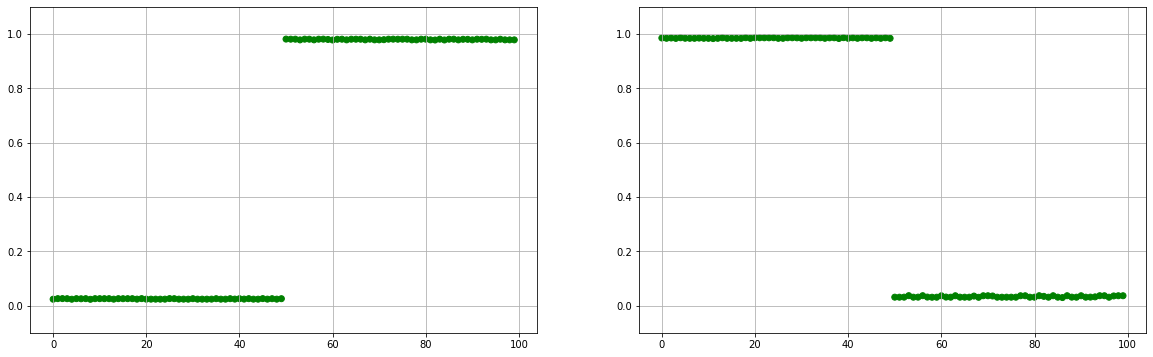

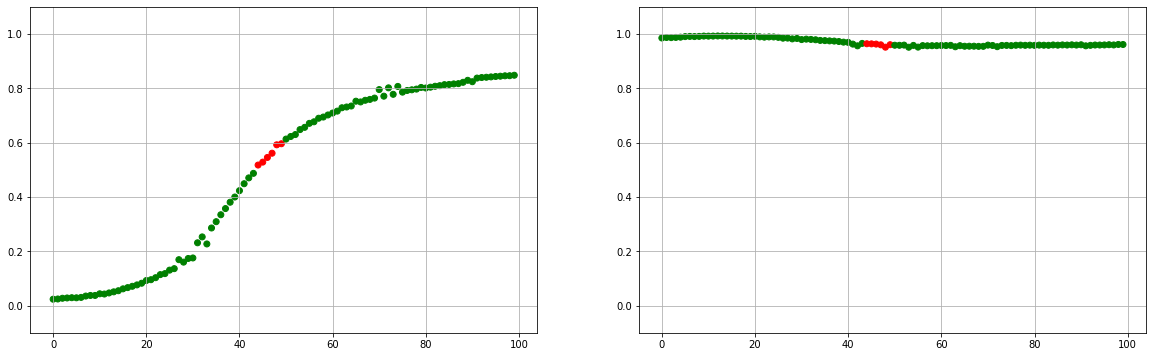

In [19]:
qplt.show_QCNN_classification2D(myqcnn)

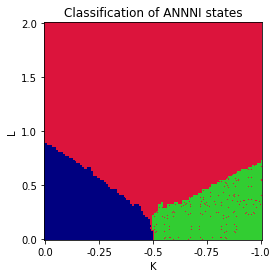

In [20]:
qplt.show_QCNN_classificationANNNI(myqcnn, inject = False)